In [1]:
import re

# Load the book's text
with open('data/TKMBFullBook.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [2]:
chapters = re.split(r'Chapter \d+', text)
if chapters[0].strip() == "":
    chapters.pop(0) # Remove the empty string before the first chapter

In [3]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

def sentence_chunks(text, tokenizer, max_tokens=450, overlap_tokens=60):
    """
    Greedy pack sentences into chunks under max_tokens using the model tokenizer.
    Adds a small sentence-level overlap between adjacent chunks using tokens.
    """
    sents = sent_tokenize(text)
    chunks = []
    current = []
    current_tokens = 0

    def tok_len(t):
        return len(tokenizer.tokenize(t))

    i = 0
    while i < len(sents):
        s = sents[i]
        s_tokens = tok_len(s)
        if s_tokens > max_tokens:
            # Very long sentence: hard split by words as a rare fallback
            words = s.split()
            # keep ~max_tokens-10 tokens margin when splitting
            step = max(1, int(len(words) * (max_tokens / (s_tokens + 1e-9))))
            for wstart in range(0, len(words), step):
                piece = " ".join(words[wstart:wstart+step])
                chunks.append(piece)
            i += 1
            current, current_tokens = [], 0
            continue

        if current_tokens + s_tokens <= max_tokens:
            current.append(s)
            current_tokens += s_tokens
            i += 1
        else:
            # finalize current chunk
            if current:
                chunk_text = " ".join(current)
                chunks.append(chunk_text)

                # build overlap buffer from the end of current
                if overlap_tokens > 0:
                    back = []
                    back_tokens = 0
                    for sent in reversed(current):
                        tl = tok_len(sent)
                        if back_tokens + tl > overlap_tokens:
                            break
                        back.append(sent)
                        back_tokens += tl
                    current = list(reversed(back))
                    current_tokens = sum(tok_len(x) for x in current)
                else:
                    current, current_tokens = [], 0
            else:
                # edge case: single sentence larger than budget handled above
                i += 1

    if current:
        chunks.append(" ".join(current))

    return chunks


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\salij\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-mpnet-base-v2')
tokenizer = model.tokenizer

W0830 05:48:18.521000 21968 torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


In [5]:
all_chunks = []
for chap_num, chap_text in enumerate(chapters, start=1):
    for i, chunk in enumerate(sentence_chunks(chap_text, tokenizer,
                                              max_tokens=450, overlap_tokens=60), start=1):
        all_chunks.append({
            "chapter": chap_num,
            "chunk_id": f"{chap_num}_{i}",
            "text": chunk
        })

In [6]:
print(f"Total chunks created: {len(all_chunks)}")
print(f"Example chunk: {all_chunks[50]}")

Total chunks created: 369
Example chunk: {'chapter': 5, 'chunk_id': '5_1', 'text': '\n My nagging got the better of Jem eventually, as I knew it would, and to my relief \nwe slowed down the game for a while. He still maintained, however, that Atticus \nhadn’t said we couldn’t, therefore we could; and if Atticus ever said we couldn’t, \nJem had thought of a way around it: he would simply change the names of the \ncharacters and then we couldn’t be accused of playing anything. Dill was in hearty agreement with this plan of action. Dill was becoming \nsomething of a trial anyway, following Jem about. He had asked me earlier in the \nsummer to marry him, then he promptly forgot about it. He staked me out, marked \nas his property, said I was the only girl he would ever love, then he neglected me. I beat him up twice but it did no good, he only grew closer to Jem. They spent \ndays together in the treehouse plotting and planning, calling me only when they \nneeded a third party. But I kept 

In [7]:
texts = [chunk['text'] for chunk in all_chunks]
embeddings = model.encode(texts, convert_to_tensor=False, show_progress_bar=True, batch_size=32)

Batches:   0%|          | 0/12 [00:00<?, ?it/s]

In [8]:
embeddings[1]  # Example to show the embedding of the second chunk

array([-2.57084407e-02,  6.11791164e-02,  1.40771829e-03,  1.75060723e-05,
       -3.98007333e-02,  1.92359816e-02, -1.53717324e-02, -8.10483098e-03,
        1.40671153e-02, -2.97832191e-02,  8.98269285e-03,  7.66535178e-02,
        6.14860393e-02, -5.38585596e-02, -2.29360051e-02,  4.69067059e-02,
       -2.75505371e-02,  4.83390950e-02,  3.67982350e-02,  1.01526929e-02,
       -2.65493859e-02,  4.19890098e-02,  2.33274307e-02, -2.60379110e-02,
        2.98224483e-02, -7.44916219e-03,  8.91691260e-03,  3.84011082e-02,
       -4.92018536e-02, -1.33131891e-02, -7.92668760e-03,  8.66289530e-03,
       -1.41528379e-02, -3.42739448e-02,  2.10065696e-06,  1.27481902e-02,
        2.46044155e-02, -2.07386054e-02, -2.75453031e-02,  3.72424237e-02,
        6.75441101e-02,  2.17401795e-02,  1.97675619e-02,  1.94610003e-02,
       -5.75919561e-02,  9.86258406e-03, -5.01122251e-02,  1.19426530e-02,
       -2.92861033e-02,  8.20831489e-03,  6.88517559e-03,  1.28594544e-02,
        2.61526760e-02,  

In [9]:
embeddings.shape

(369, 768)

Indexing With FAISS (Facebook AI Similarity Search) on chunk/Paragraph level

In [10]:
import faiss
import numpy as np

# Convert to float32 ( required for FAISS)
embedding_matrix = np.array(embeddings).astype('float32')

# Build index (using cosine)
dimension = embedding_matrix.shape[1]
index = faiss.IndexFlatIP(dimension)  # Inner Product = Cosine similarity (after normalization)

# Normalize for cosine similarity
faiss.normalize_L2(embedding_matrix)

# Add vectors
index.add(embedding_matrix)

In [11]:
def search_faiss(query, top_k=5):
    # Encode and normalize query
    query_vec = model.encode([query], convert_to_numpy=True)
    faiss.normalize_L2(query_vec)

    # Search index
    scores, indices = index.search(query_vec, top_k)

    # Retrieve the corresponding chunks
    results = []
    for i, score in zip(indices[0], scores[0]):
        result = {
            "chunk_id": all_chunks[i]["chunk_id"],
            "chapter": all_chunks[i]["chapter"],
            "text": all_chunks[i]["text"],
            "score": float(score)
        }
        results.append(result)
    
    return results


In [12]:
import openai
from openai import OpenAI
import os

#  OpenAI API key

client = OpenAI(api_key = os.environ.get("OPENAI_API_KEY")) #Using environmental variable

#generate text
def generate_text(prompt: str) -> str:
    """Generates text using the OpenAI API based on the provided prompt."""
    
    # Make the API call
    response = client.chat.completions.create(
        model="gpt-4.1-mini",  
        messages=[{"role": "system", "content": "You are a creative short story writer who writes stories in a specified book/novel style and answer questions based on it."},
                  {"role": "user", "content": prompt}],
        temperature=0.7,  # Adjust temperature for creativity
    )
    
    return response.choices[0].message.content.strip()

In [13]:
#generated_text = generate_text("In the novel 'To Kill a Mockingbird' what was happening to Jem?")
##print(generated_text)
generated_text = "In Harper Lee’s novel *To Kill a Mockingbird*, Jem Finch experiences a significant and poignant transformation throughout the story, both emotionally and physically. As the novel progresses, Jem is moving from childhood innocence into a more mature understanding of the complexities and injustices of the world around him. Specifically, by the later parts of the novel, Jem is struggling with the harsh realities following the trial of Tom Robinson. He is grappling with the unfair verdict and the ingrained racism he witnesses in Maycomb, which deeply affects his sense of justice and morality. This internal conflict causes Jem to become more serious and introspective. Physically, he is also growing up—he is older and stronger than Scout, and his changing body mirrors the changes in his perceptions and attitude. Additionally, after the attack by Bob Ewell near the end of the novel, Jem is injured and unconscious for a time, which symbolizes the physical and emotional toll that the town’s prejudice and violence have taken on him. So, Jem is undergoing a painful but necessary coming-of-age experience, marked by both personal growth and the loss of childhood innocence."

import ollama

# create query
response = ollama.generate(
  model="llama3",  
  prompt="who is obama",
)

# print reesponse
print(response["response"])

In [14]:
query = generated_text
top_results = search_faiss(query, top_k=10)

for res in top_results:
    print(f"Chapter {res['chapter']} | Chunk {res['chunk_id']} | Score: {res['score']:.3f}")
    print(res['text'])
    print("---")


Chapter 12 | Chunk 12_1 | Score: 0.712

 Jem was twelve. He was difficult to live with, inconsistent, moody. His appetite 
was appalling, and he told me so many times to stop pestering him I consulted 
Atticus: “Reckon he’s got a tapeworm?” Atticus said no, Jem was growing. I must 
be patient with him and disturb him as little as possible. This change in Jem had come about in a matter of weeks. Mrs. Dubose was not 
cold in her grave—Jem had seemed grateful enough for my company when he 
went to read to her. Overnight, it seemed, Jem had acquired an alien set of values 
and was trying to impose them on me: several times he went so far as to tell me 
what to do. After one altercation when Jem hollered, “It’s time you started bein‘ a 
girl and acting right!” I burst into tears and fled to Calpurnia. “Don’t you fret too much over Mister Jem—” she began. “Mister Jem?”
 “Yeah, he’s just about Mister Jem now.”
 “He ain’t that old,” I said. “All he needs is somebody to beat him up, and I ain’t

In [15]:
#calculate precision at k
def calculate_precision_at_k(retrieved, relevant, k):
    retrieved = retrieved[:k]
    relevant_set = set(relevant)
    num_relevant_retrieved = sum(1 for doc in retrieved if doc in relevant_set)
    return num_relevant_retrieved / k if k > 0 else 0.0

#calculate recall at k
def calculate_recall_at_k(retrieved, relevant, k):
    retrieved = retrieved[:k]
    relevant_set = set(relevant)
    num_relevant_retrieved = sum(1 for doc in retrieved if doc in relevant_set)
    return num_relevant_retrieved / len(relevant_set) if relevant_set else 0.0

#calculate f1 score at k
def calculate_f1_at_k(retrieved, relevant, k):
    precision = calculate_precision_at_k(retrieved, relevant, k)
    recall = calculate_recall_at_k(retrieved, relevant, k)
    if precision + recall > 0:
        return 2 * (precision * recall) / (precision + recall)
    return 0.0

#calculate MRR
def calculate_mrr(retrieved, relevant):
    mrr = 0.0
    for i, doc in enumerate(retrieved):
        if doc in relevant:
            mrr = 1 / (i + 1)
            break
    return mrr

#Calculate nDCG
def calculate_ndcg(retrieved, relevant):
    dcg = 0.0
    idcg = 0.0
    for i, doc in enumerate(retrieved):
        if doc in relevant:
            dcg += 1 / (np.log2(i + 2))
    for i, doc in enumerate(relevant):
        idcg += 1 / (np.log2(i + 2))
    return dcg / idcg if idcg > 0 else 0.0

#calculate accuracy
def calculate_accuracy(retrieved, relevant):
    relevant_set = set(relevant)
    num_correct = sum(1 for doc in retrieved if doc in relevant_set)
    return num_correct / len(relevant_set) if relevant_set else 0.0

relevant_docs = {"1_1","7_1", "9_18", "12_1", "28_15","10_1", "26_8", "30_4", "11_8", "15_11"}  # relevant doc ids for a single query
retrieved_docs = [r["chunk_id"] for r in top_results]  # retrieved doc ids from the search results

#relevant_docs = {"1","7", "9", "10", "11","12","15","26","28","30"}
#use the chapter number as the retrieved doc id
#retrieved_docs = [r["chapter"] for r in top_results]  # retrieved doc ids from the search results

print("Precision at k:", calculate_precision_at_k(retrieved_docs, relevant_docs, k=10))
print("Recall at k:", calculate_recall_at_k(retrieved_docs, relevant_docs, k=10))
print("F1 at k:", calculate_f1_at_k(retrieved_docs, relevant_docs, k=10))
print("MRR:", calculate_mrr(retrieved_docs, relevant_docs))
print("nDCG:", calculate_ndcg(retrieved_docs, relevant_docs))
print("Accuracy:", calculate_accuracy(retrieved_docs, relevant_docs))

Precision at k: 0.8
Recall at k: 0.8
F1 at k: 0.8000000000000002
MRR: 1.0
nDCG: 0.8603818544462509
Accuracy: 0.8


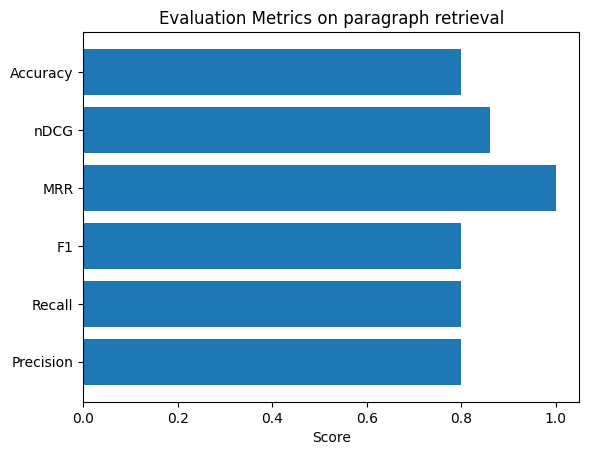

In [16]:
#plot the results
import matplotlib.pyplot as plt

metrics = {
    "Precision": calculate_precision_at_k(retrieved_docs, relevant_docs, k=10),
    "Recall": calculate_recall_at_k(retrieved_docs, relevant_docs, k=10),
    "F1": calculate_f1_at_k(retrieved_docs, relevant_docs, k=10),
    "MRR": calculate_mrr(retrieved_docs, relevant_docs),
    "nDCG": calculate_ndcg(retrieved_docs, relevant_docs),
    "Accuracy": calculate_accuracy(retrieved_docs, relevant_docs)
}

plt.barh(list(metrics.keys()), list(metrics.values()))
plt.xlabel("Score")
plt.title("Evaluation Metrics on paragraph retrieval")
plt.show()


In [ ]:
#plot precision against recall


In [ ]:
#roc curve corresponding to precsion and recall

Retrieving on chapter level

In [17]:
from collections import defaultdict
import numpy as np
import faiss

def search_faiss_grouped(
    query: str,
    topN_chunks: int = 100,     # how many chunks to pull from FAISS
    top_chapters: int = 10,      # how many chapters to return
    per_chapter: int = 3,        # how many top chunks to keep per chapter
    agg: str = "max"             # chapter score: "max" or "mean" of its chunk scores
):
    """
    FAISS-only retrieval grouped by chapter.
    Returns a list of 'cards' sorted by chapter_score desc:
      [{
         'chapter': <int>,
         'chapter_score': <float>,
         'chunks': [
             {'chunk_id': str, 'chapter': int, 'text': str, 'retrieval_score': float}, ...
         ]
      }, ...]
    """
    # 1) Encode + normalize query (cosine via IP on L2-normalized vectors)
    q = model.encode([query], convert_to_numpy=True)  # SentenceTransformer
    faiss.normalize_L2(q)

    # 2) Retrieve topN chunks
    scores, idxs = index.search(q, topN_chunks)

    # 3) Build candidate list
    candidates = []
    for j, i in enumerate(idxs[0]):
        candidates.append({
            "chunk_id":        all_chunks[i]["chunk_id"],
            "chapter":         all_chunks[i]["chapter"],
            "text":            all_chunks[i]["text"],
            "retrieval_score": float(scores[0][j]),
            "_idx":            int(i)
        })

    if not candidates:
        return []

    # 4) Group by chapter
    buckets = defaultdict(list)
    for c in candidates:
        buckets[c["chapter"]].append(c)

    # 5) Score chapters + keep top chunks per chapter
    cards = []
    for chap, items in buckets.items():
        # sort chunks within chapter by retrieval score
        items.sort(key=lambda x: x["retrieval_score"], reverse=True)
        if agg == "mean":
            chapter_score = float(np.mean([x["retrieval_score"] for x in items]))
        else:  # "max" (default)
            chapter_score = float(items[0]["retrieval_score"])
        cards.append({
            "chapter": chap,
            "chapter_score": chapter_score,
            "chunks": items[:per_chapter]
        })

    # 6) Sort chapters + return top_chapters
    cards.sort(key=lambda x: x["chapter_score"], reverse=True)
    return cards[:top_chapters]


In [18]:
chapter_results = search_faiss_grouped(generated_text, topN_chunks=100, top_chapters=10, per_chapter=3, agg="max")


In [19]:
chapter_results

[{'chapter': 12,
  'chapter_score': 0.7120361328125,
  'chunks': [{'chunk_id': '12_1',
    'chapter': 12,
    'text': '\n Jem was twelve. He was difficult to live with, inconsistent, moody. His appetite \nwas appalling, and he told me so many times to stop pestering him I consulted \nAtticus: “Reckon he’s got a tapeworm?” Atticus said no, Jem was growing. I must \nbe patient with him and disturb him as little as possible. This change in Jem had come about in a matter of weeks. Mrs. Dubose was not \ncold in her grave—Jem had seemed grateful enough for my company when he \nwent to read to her. Overnight, it seemed, Jem had acquired an alien set of values \nand was trying to impose them on me: several times he went so far as to tell me \nwhat to do. After one altercation when Jem hollered, “It’s time you started bein‘ a \ngirl and acting right!” I burst into tears and fled to Calpurnia. “Don’t you fret too much over Mister Jem—” she began. “Mister Jem?”\n “Yeah, he’s just about Mister Jem

In [20]:
from typing import List, Set
import math

#evaluate after rerank
def precisionatk(ranked: List[str], gold: Set[str], k: int) -> float:
    if k == 0:
        return 0.0
    preds = set(ranked[:k])
    return len(preds & gold) / len(preds) if preds else 0.0

def recallatk(ranked: List[str], gold: Set[str], k: int) -> float:
    if k == 0 or not gold:
        return 0.0
    preds = set(ranked[:k])
    return len(preds & gold) / len(gold)

def f1atk(ranked: List[str], gold: Set[str], k: int) -> float:
    p = precisionatk(ranked, gold, k)
    r = recallatk(ranked, gold, k)
    if p + r == 0:
        return 0.0
    return 2 * p * r / (p + r)

def averageP(ranked: List[str], gold: Set[str], k: int) -> float:
    return sum(precisionatk(ranked, gold, i) for i in range(1, k + 1)) / k

def meanReciprocalRank(ranked: List[str], gold: Set[str]) -> float:
    for i, doc in enumerate(ranked):
        if doc in gold:
            return 1 / (i + 1)
    return 0.0

def ndcg(ranked: List[str], gold: Set[str], k: int) -> float:
    dcg = sum(1 / math.log2(i + 2) for i, doc in enumerate(ranked[:k]) if doc in gold)
    idcg = sum(1 / math.log2(i + 2) for i in range(len(gold)))
    return dcg / idcg if idcg > 0 else 0.0

def accuracy(ranked: List[str], gold: Set[str]) -> float:
    if not ranked:
        return 0.0
    return sum(1 for doc in ranked if doc in gold) / len(ranked)

ground_truth = {
    "query1": {"1","7", "9", "10", "11","12","15","26","28","30"},
    
}

# Flatten all chunk_ids from Rerank_results
#predicted = [chunk["chunk_id"] for card in Rerank_results for chunk in card["chunks"]] "26_8", "30_4", "11_8", "15_11

best_chapters = [c["chapter"] for c in chapter_results]
gold_chapters = {int(ch.split('_')[0]) for ch in ground_truth["query1"]}  # extract chapter numbers



#k = 10


#predicted = [card["chapter"] for card in Rerank_results]
#gold_chapters = {int(c.split('_')[0]) for c in ground_truth["query1"]}

print("precision@5:", precisionatk(best_chapters, gold_chapters, 5))
print("precision@10:", precisionatk(best_chapters, gold_chapters, 10))
print("recall@5:", recallatk(best_chapters, gold_chapters, 5))
print("recall@10:", recallatk(best_chapters, gold_chapters, 10))
print("F1@5:", f1atk(best_chapters, gold_chapters, 5))
print("F1@10:", f1atk(best_chapters, gold_chapters, 10))
print("MAP@5:", averageP(best_chapters, gold_chapters, 5))
print("MAP@10:", averageP(best_chapters, gold_chapters, 10))
print("MRR:", meanReciprocalRank(best_chapters, gold_chapters))
print("NDCG@5:", ndcg(best_chapters, gold_chapters, 5))
print("NDCG@10:", ndcg(best_chapters, gold_chapters, 10))
print("Accuracy:", accuracy(best_chapters, gold_chapters))


precision@5: 1.0
precision@10: 0.9
recall@5: 0.5
recall@10: 0.9
F1@5: 0.6666666666666666
F1@10: 0.9
MAP@5: 1.0
MAP@10: 0.9788888888888889
MRR: 1.0
NDCG@5: 0.6489315753318465
NDCG@10: 0.933745776545611
Accuracy: 0.9


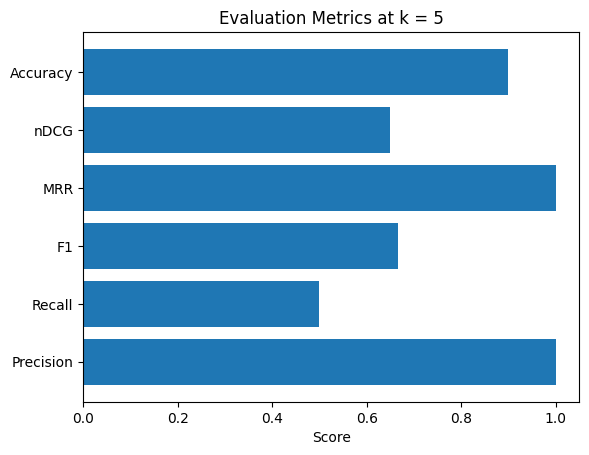

In [21]:
chapter_metrics = {
    "Precision": precisionatk(best_chapters, gold_chapters, 5),
    "Recall": recallatk(best_chapters, gold_chapters, 5),
    "F1": f1atk(best_chapters, gold_chapters, 5),
    "MRR": meanReciprocalRank(best_chapters, gold_chapters),
    "nDCG": ndcg(best_chapters, gold_chapters, 5),
    "Accuracy": accuracy(best_chapters, gold_chapters)
}

plt.barh(list(chapter_metrics.keys()), list(chapter_metrics.values()))
plt.xlabel("Score")
plt.title("Evaluation Metrics at k = 5")
plt.show()

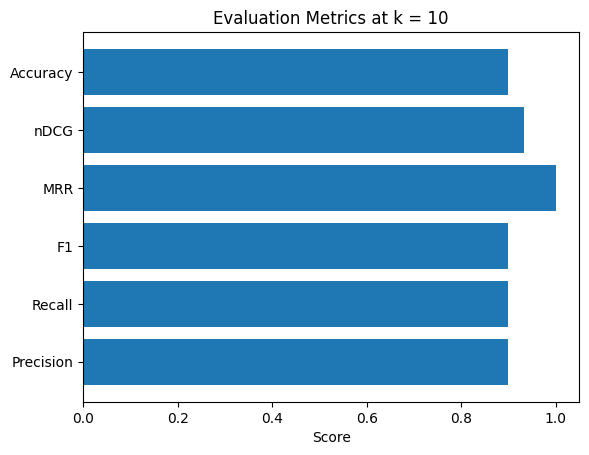

In [22]:
chapter_metrics = {
    "Precision": precisionatk(best_chapters, gold_chapters, 10),
    "Recall": recallatk(best_chapters, gold_chapters, 10),
    "F1": f1atk(best_chapters, gold_chapters, 10),
    "MRR": meanReciprocalRank(best_chapters, gold_chapters),
    "nDCG": ndcg(best_chapters, gold_chapters, 10),
    "Accuracy": accuracy(best_chapters, gold_chapters)
}

plt.barh(list(chapter_metrics.keys()), list(chapter_metrics.values()))
plt.xlabel("Score")
plt.title("Evaluation Metrics at k = 10")
plt.show()

ReRanking With Cross Encoder

In [23]:
from sentence_transformers import CrossEncoder
_reranker = None

def get_reranker():
    global _reranker
    if _reranker is None:
        _reranker = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')
    return _reranker

In [24]:
# Get the first chunk text for each chapter in chapter_results
chapter_texts = []
for chap in chapter_results:
    for chunk in all_chunks:
        if chunk["chapter"] == chap:
            chapter_texts.append(chunk["text"])
            break

reranker = get_reranker()
# Rerank based on both chapter and chunk relevance
chapter_chunk_pairs = []         # pairs for reranker
chapter_chunk_ids = []           # (chapter, chunk_id)
chapter_chunk_texts = []         # chunk texts aligned with ids

# collect candidate chunks from all chapters in best_chapters
TOP_CHUNKS_PER_CHAPTER = 10
for chap in best_chapters:
    relevant_chunks = [chunk for chunk in all_chunks if chunk["chapter"] == chap]
    for chunk in relevant_chunks[:TOP_CHUNKS_PER_CHAPTER]:
        chapter_chunk_pairs.append((generated_text, chunk["text"]))
        chapter_chunk_ids.append((chunk["chapter"], chunk["chunk_id"]))
        chapter_chunk_texts.append(chunk["text"])

# Score with reranker
if chapter_chunk_pairs:
    chunk_scores = reranker.predict(chapter_chunk_pairs, batch_size=32)
else:
    chunk_scores = []

# Build combined records aligned correctly
combined = []
for (chap, cid), text, score in zip(chapter_chunk_ids, chapter_chunk_texts, chunk_scores):
    combined.append({"chapter": int(chap), "chunk_id": cid, "text": text, "score": float(score)})

# 1) Global ranking across all chapters/chunks
combined_sorted = sorted(combined, key=lambda x: x["score"], reverse=True)

#print("Top ranked chunks (global):")
#for idx, item in enumerate(combined_sorted[:20], start=1):
    #print(f"Rank {idx} | Score: {item['score']:.4f} | Chapter: {item['chapter']} | Chunk: {item['chunk_id']}")
    #print(item['text'][:300] + ("..." if len(item['text']) > 300 else ""))
    #print("---")

# 2) Chapter-level aggregation (e.g., max chunk score per chapter)
from collections import defaultdict
chap_buckets = defaultdict(list)
for it in combined:
    chap_buckets[it['chapter']].append(it)

cards = []
PER_CHAPTER_KEEP = 3
for chap, items in chap_buckets.items():
    items.sort(key=lambda x: x['score'], reverse=True)
    chapter_score = items[0]['score'] if items else 0.0
    cards.append({
        'chapter': chap,
        'chapter_score': chapter_score,
        'chunks': items[:PER_CHAPTER_KEEP]
    })

cards.sort(key=lambda x: x['chapter_score'], reverse=True)

print('\nChapter-level ranking (aggregated from chunk scores):')
for i, c in enumerate(cards[:10], start=1):
    print(f"{i}. Chapter {c['chapter']} | Score: {c['chapter_score']:.4f} | top_chunks: {[ch['chunk_id'] for ch in c['chunks']]}")

# Provide variables for downstream cells 1","7", "9", "10", "11","12","15","26","28","30"
reranked_combined = combined_sorted
reranked_cards = cards


README.md: 0.00B [00:00, ?B/s]


Chapter-level ranking (aggregated from chunk scores):
1. Chapter 10 | Score: 0.4064 | top_chunks: ['10_2', '10_9', '10_6']
2. Chapter 7 | Score: 0.0436 | top_chunks: ['7_6', '7_1', '7_3']
3. Chapter 12 | Score: -0.4951 | top_chunks: ['12_3', '12_1', '12_7']
4. Chapter 11 | Score: -0.5160 | top_chunks: ['11_4', '11_10', '11_3']
5. Chapter 9 | Score: -0.7731 | top_chunks: ['9_7', '9_4', '9_1']
6. Chapter 30 | Score: -0.8835 | top_chunks: ['30_4', '30_3', '30_6']
7. Chapter 15 | Score: -1.0140 | top_chunks: ['15_8', '15_10', '15_1']
8. Chapter 28 | Score: -1.6255 | top_chunks: ['28_3', '28_7', '28_2']
9. Chapter 26 | Score: -2.2038 | top_chunks: ['26_8', '26_7', '26_3']
10. Chapter 31 | Score: -2.7412 | top_chunks: ['31_6', '31_4', '31_5']


In [25]:
#evaluate the performance of the reranking
best_reranked = [c["chapter"] for c in reranked_cards]
gold_chapters = {int(ch.split('_')[0]) for ch in ground_truth["query1"]}  # extract chapter numbers



print("precision@5:", precisionatk(best_reranked, gold_chapters, 5))
print("precision@10:", precisionatk(best_reranked, gold_chapters, 10))
print("recall@5:", recallatk(best_reranked, gold_chapters, 5))
print("recall@10:", recallatk(best_reranked, gold_chapters, 10))
print("F1@5:", f1atk(best_reranked, gold_chapters, 5))
print("F1@10:", f1atk(best_reranked, gold_chapters, 10))
print("MAP@5:", averageP(best_reranked, gold_chapters, 5))
print("MAP@10:", averageP(best_reranked, gold_chapters, 10))
print("MRR:", meanReciprocalRank(best_reranked, gold_chapters))
print("NDCG@5:", ndcg(best_reranked, gold_chapters, 5))
print("NDCG@10:", ndcg(best_reranked, gold_chapters, 10))
print("Accuracy:", accuracy(best_reranked, gold_chapters))

precision@5: 1.0
precision@10: 0.9
recall@5: 0.5
recall@10: 0.9
F1@5: 0.6666666666666666
F1@10: 0.9
MAP@5: 1.0
MAP@10: 0.99
MRR: 1.0
NDCG@5: 0.6489315753318465
NDCG@10: 0.9363792118010483
Accuracy: 0.9


In [51]:
# FAISS -> Cross-Encoder re-ranking
# topN: how many candidates to pull from FAISS before re-ranking
# final_topk: how many to return after re-ranking

from collections import defaultdict

def search_faiss_rerank(query, topN=100, final_topk=10, group_by_chapter=True, per_chapter=3, batch_size=32):
    # 1) Retrieve candidates with FAISS
    import faiss
    q = model.encode([query], convert_to_numpy=True)
    faiss.normalize_L2(q)
    scores, idxs = index.search(q, topN)

    candidates = []
    for j, i in enumerate(idxs[0]):
        candidates.append({
            "chunk_id": all_chunks[i]["chunk_id"],
            "chapter": all_chunks[i]["chapter"],
            "text": all_chunks[i]["text"],
            "retrieval_score": float(scores[0][j]),
            "_idx": int(i)
        })

    if not candidates:
        return []
      # 2) Re-rank with cross-encoder
    ce = get_reranker()
    pairs = [(query, c["text"]) for c in candidates]
    ce_scores = ce.predict(pairs, batch_size=batch_size)
    for c, s in zip(candidates, ce_scores):
        c["ce_score"] = float(s)

    # 3) Sort by CE score and slice
    candidates.sort(key=lambda x: x["ce_score"], reverse=True)
    top = candidates[:final_topk]

    if not group_by_chapter:
        return top

    # 4) chapter-aware grouping
    buckets = defaultdict(list)
    
    for c in top:
        buckets[c["chapter"]].append(c)

    cards = []
    for chap, items in buckets.items():
        items.sort(key=lambda x: x["ce_score"], reverse=True)
        chapter_score = max(i["ce_score"] for i in items)
        cards.append({
            "chapter": chap,
            "chapter_score": chapter_score,
            "chunks": items[:per_chapter]
        })

    cards.sort(key=lambda x: x["chapter_score"], reverse=True)
    return cards
rerank_results = search_faiss_rerank(generated_text, topN=100, final_topk=10, group_by_chapter=True, per_chapter=3, batch_size=32)
rerank_results

[{'chapter': 7,
  'chapter_score': 0.0435725562274456,
  'chunks': [{'chunk_id': '7_6',
    'chapter': 7,
    'text': 'I bet it’s Miss Maudie—been bettin‘ that for a \nlong time.”\n “Ar-r, Miss Maudie can’t chew gum—” Jem broke into a grin. “You know, she \ncan talk real pretty sometimes. One time I asked her to have a chew and she said \nno thanks, that—chewing gum cleaved to her palate and rendered her speechless,” \nsaid Jem carefully. “Doesn’t that sound nice?”\n “Yeah, she can say nice things sometimes. She wouldn’t have a watch and chain \nanyway.”\n “Dear sir,” said Jem. “We appreciate the—no, we appreciate everything which \nyou have put into the tree for us. Yours very truly, Jeremy Atticus Finch.”\n “He won’t know who you are if you sign it like that, Jem.”\n Jem erased his name and wrote, “Jem Finch.” I signed, “Jean Louise Finch \n(Scout),” beneath it. Jem put the note in an envelope. Next morning on the way to school he ran ahead of me and stopped at the tree. Jem was faci

In [48]:
predicted = [card["chapter"] for card in rerank_results]
gold_chapters = {int(c.split('_')[0]) for c in ground_truth["query1"]}

print("precision@5:", precisionatk(predicted, gold_chapters, 5))
print("precision@10:", precisionatk(predicted, gold_chapters, 10))
print("recall@5:", recallatk(predicted, gold_chapters, 5))
print("recall@10:", recallatk(predicted, gold_chapters, 10))
print("F1@5:", f1atk(predicted, gold_chapters, 5))
print("F1@10:", f1atk(predicted, gold_chapters, 10))
print("MAP@5:", averageP(predicted, gold_chapters, 5))
print("MRR:", meanReciprocalRank(predicted, gold_chapters))
print("NDCG@5:", ndcg(predicted, gold_chapters, 5))
print("Accuracy:", accuracy(predicted, gold_chapters))

precision@5: 0.8
precision@10: 0.5714285714285714
recall@5: 0.4
recall@10: 0.4
F1@5: 0.5333333333333333
F1@10: 0.47058823529411764
MAP@5: 0.8433333333333334
MRR: 1.0
NDCG@5: 0.5388856921828065
Accuracy: 0.5714285714285714


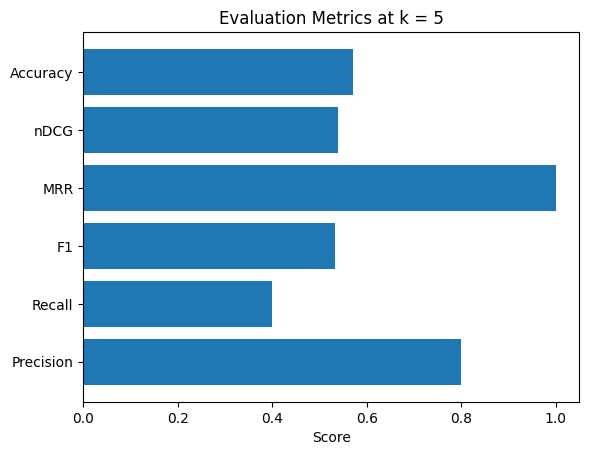

In [52]:
#plot the results
Rerank_metrics = {
    "Precision": precisionatk(predicted, gold_chapters, 5),
    "Recall": recallatk(predicted, gold_chapters, 5),
    "F1": f1atk(predicted, gold_chapters, 5),
    "MRR": meanReciprocalRank(predicted, gold_chapters),
    "nDCG": ndcg(predicted, gold_chapters, 5),
    "Accuracy": accuracy(predicted, gold_chapters)
}

plt.barh(list(Rerank_metrics.keys()), list(Rerank_metrics.values()))
plt.xlabel("Score")
plt.title("Evaluation Metrics at k = 5")
plt.show()


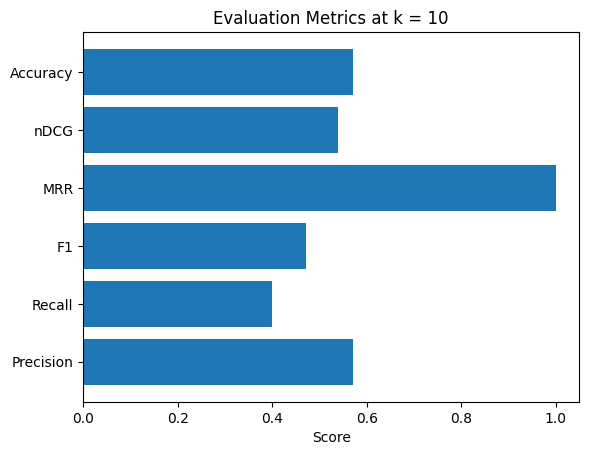

In [53]:
#plot the results
Rerank_metrics = {
    "Precision": precisionatk(predicted, gold_chapters, 10),
    "Recall": recallatk(predicted, gold_chapters, 10),
    "F1": f1atk(predicted, gold_chapters, 10),
    "MRR": meanReciprocalRank(predicted, gold_chapters),
    "nDCG": ndcg(predicted, gold_chapters, 10),
    "Accuracy": accuracy(predicted, gold_chapters)
}


plt.barh(list(Rerank_metrics.keys()), list(Rerank_metrics.values()))
plt.xlabel("Score")
plt.title("Evaluation Metrics at k = 10")
plt.show()
